In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D

# load the MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# define our model
input1 = Input(shape=(28,28,1))
input2 = Input(shape=(28,28,1))
input2c = Conv2D(32, kernel_size=(3, 3), activation='relu')(input2)
joint = tf.keras.layers.concatenate([Flatten()(input1), Flatten()(input2c)])
out = Dense(10, activation='softmax')(Dropout(0.2)(Dense(128, activation='relu')(joint)))
model = tf.keras.models.Model(inputs = [input1, input2], outputs=out)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

11501568/11490434 [==============================] - 1s 0us/step


2022-02-24 05:46:50.504750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 05:46:50.628041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 05:46:50.629233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 05:46:50.630884: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# fit the model
model.fit([x_train, x_train], y_train, epochs=3)

2022-02-24 05:46:54.358583: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3


2022-02-24 05:46:55.853366: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1875/1875 [==============================] - 13s 3ms/step - loss: 0.1663 - accuracy: 0.9499
Epoch 2/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0615 - accuracy: 0.9809
Epoch 3/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0402 - accuracy: 0.9867


In [4]:
np.array([x_train, x_train]).shape

(2, 60000, 28, 28, 1)

In [5]:
import shap

# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(model, [x_train, x_train])

# we explain the model's predictions on the first three samples of the test set
shap_values, index = explainer.shap_values([x_test[:10], x_test[:10]],ranked_outputs=10)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [6]:
index

array([[7, 9, 3, 2, 8, 5, 0, 1, 4, 6],
       [2, 1, 8, 6, 0, 3, 5, 4, 7, 9],
       [1, 4, 8, 7, 2, 5, 6, 9, 3, 0],
       [0, 7, 9, 6, 3, 1, 2, 5, 8, 4],
       [4, 9, 7, 2, 8, 0, 3, 1, 6, 5],
       [1, 7, 8, 4, 2, 9, 3, 5, 6, 0],
       [4, 8, 9, 7, 5, 1, 2, 6, 3, 0],
       [9, 4, 3, 8, 5, 7, 2, 1, 0, 6],
       [5, 6, 8, 9, 0, 3, 4, 2, 1, 7],
       [9, 4, 7, 5, 8, 3, 2, 1, 0, 6]])

In [7]:
y_test[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

In [8]:
# since the model has 10 outputs we get a list of 10 explanations (one for each output)
print(len(shap_values))

10


In [9]:
# since the model has 2 inputs we get a list of 2 explanations (one for each input) for each output
print(len(shap_values[0]))

2


In [10]:
y_test[8]

5

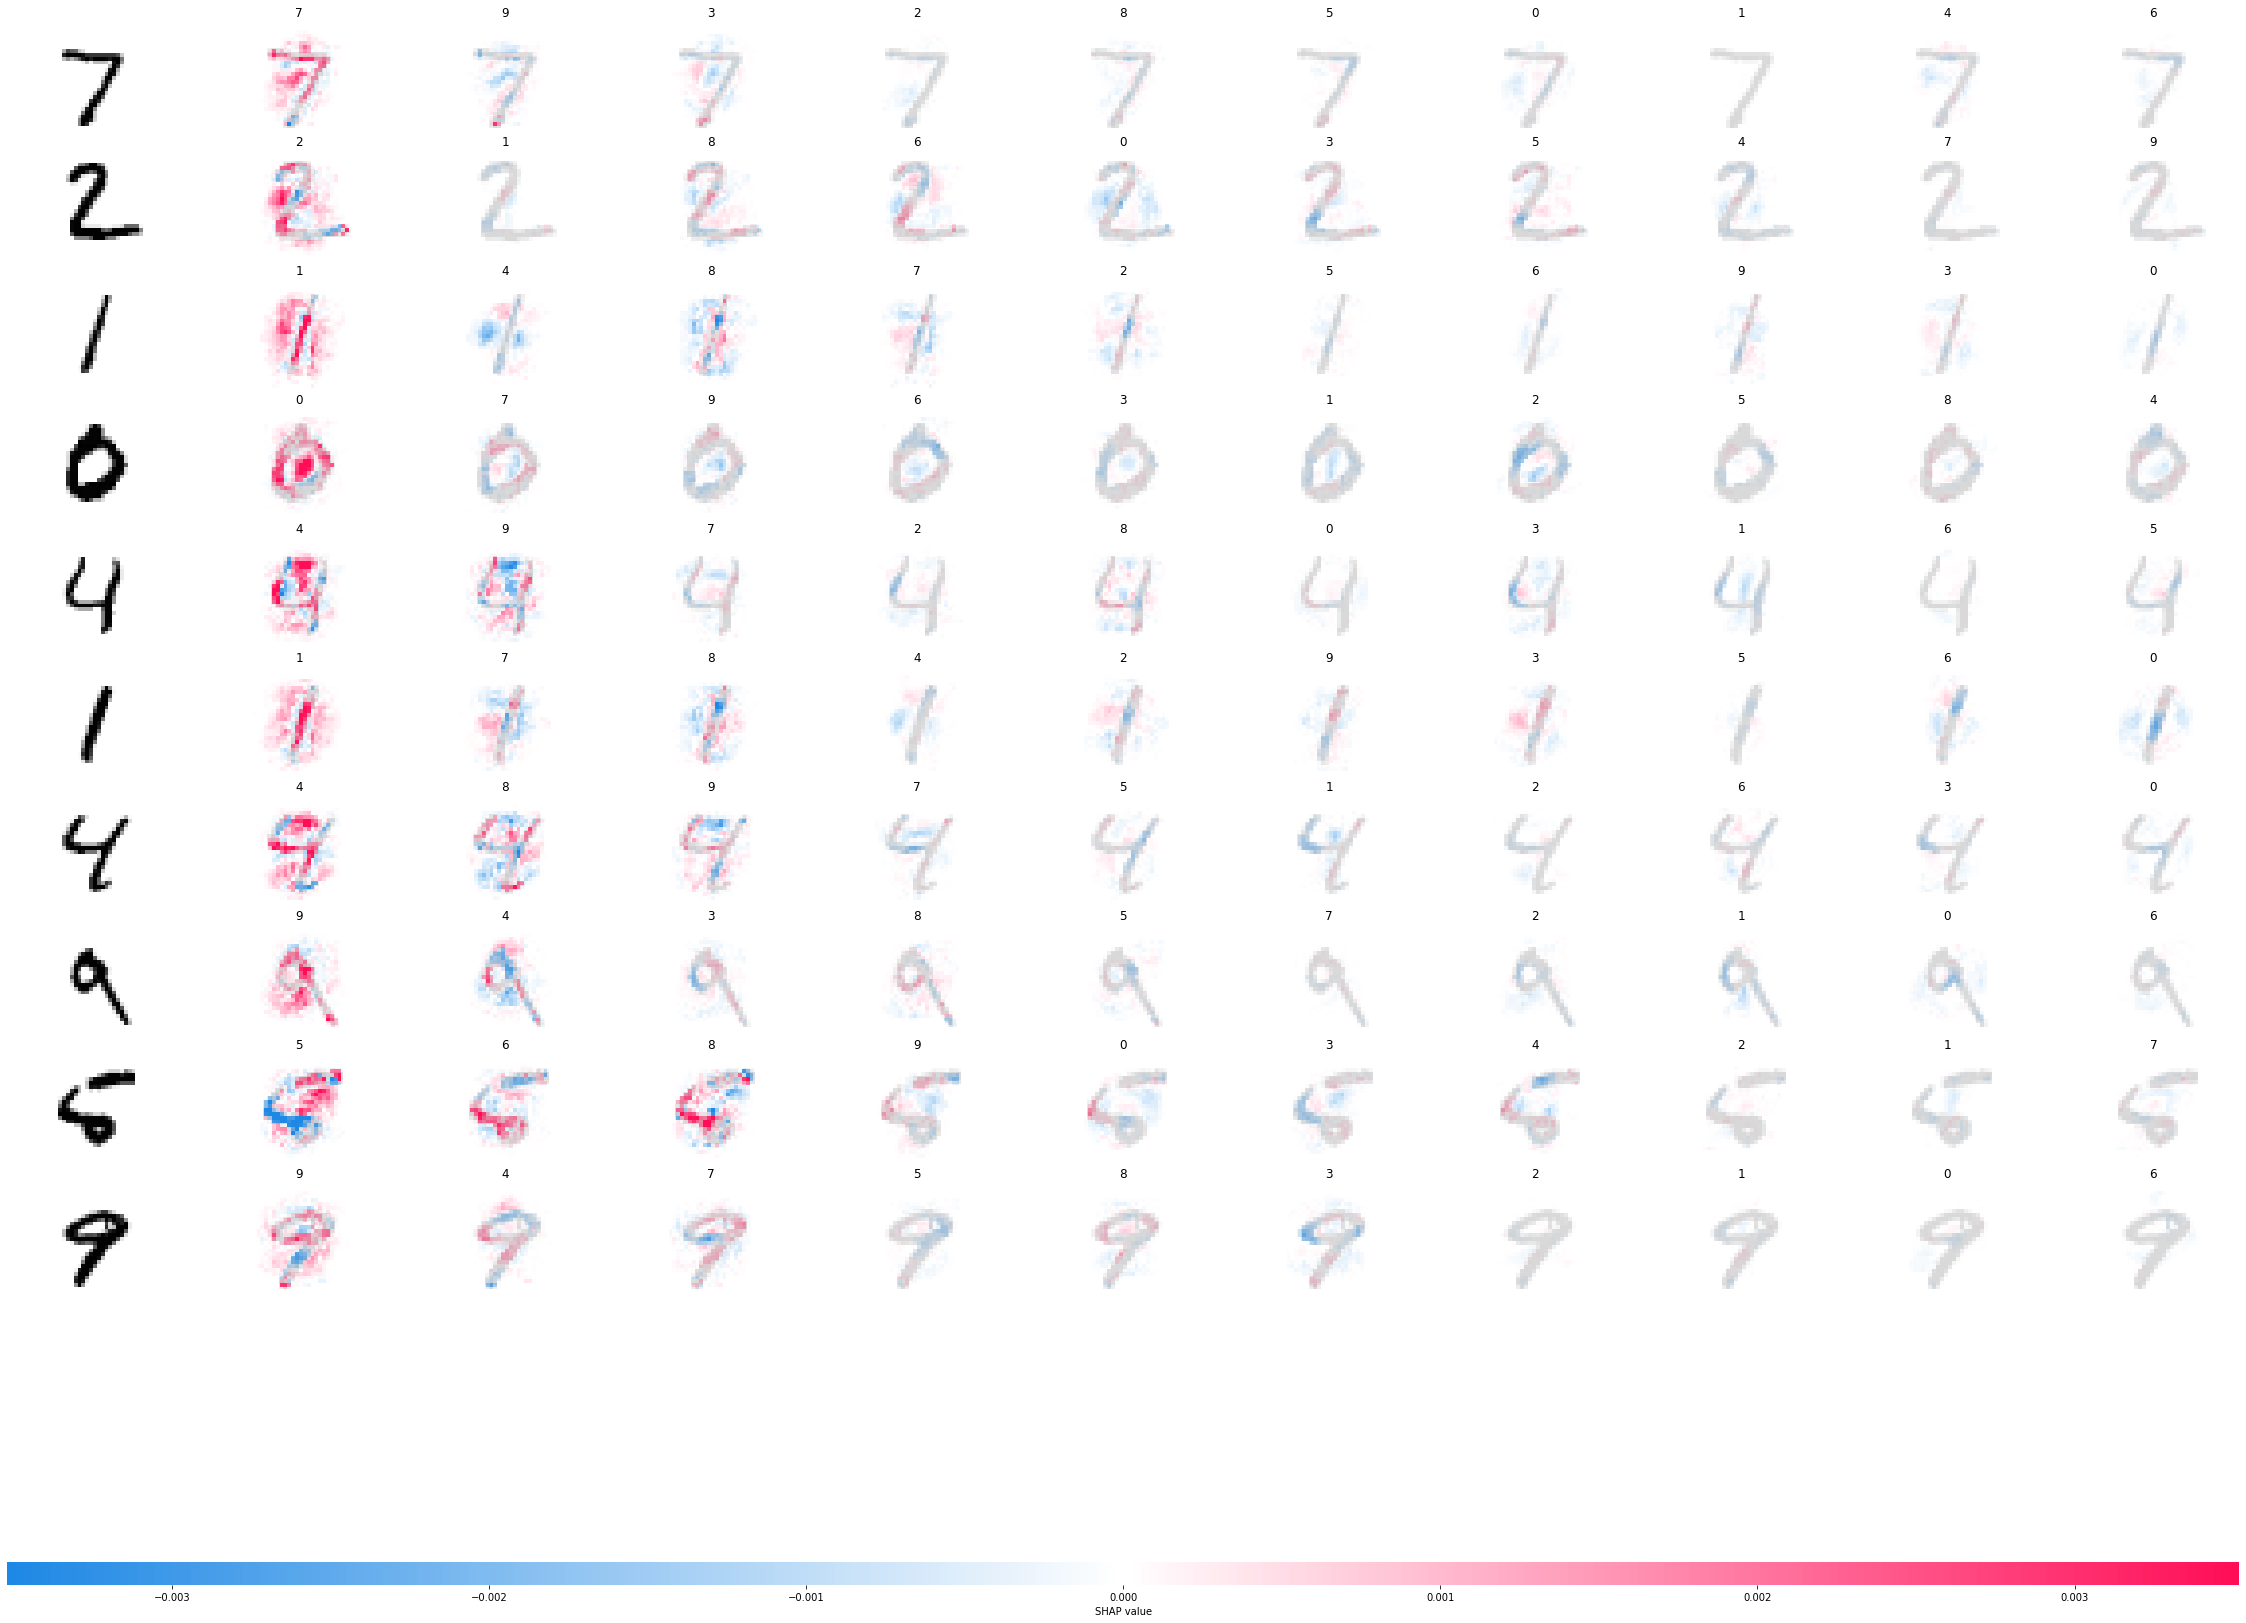

In [11]:
from matplotlib import pyplot as plt
# here we plot the explanations for all classes for the first input (this is the feed forward input)
shap.image_plot([shap_values[i][0] for i in range(10)], -x_test[:10],index,show=False)
w,h=plt.gcf().get_size_inches()
plt.gcf().set_size_inches(w*2,h*2)
plt.savefig('plt.png')

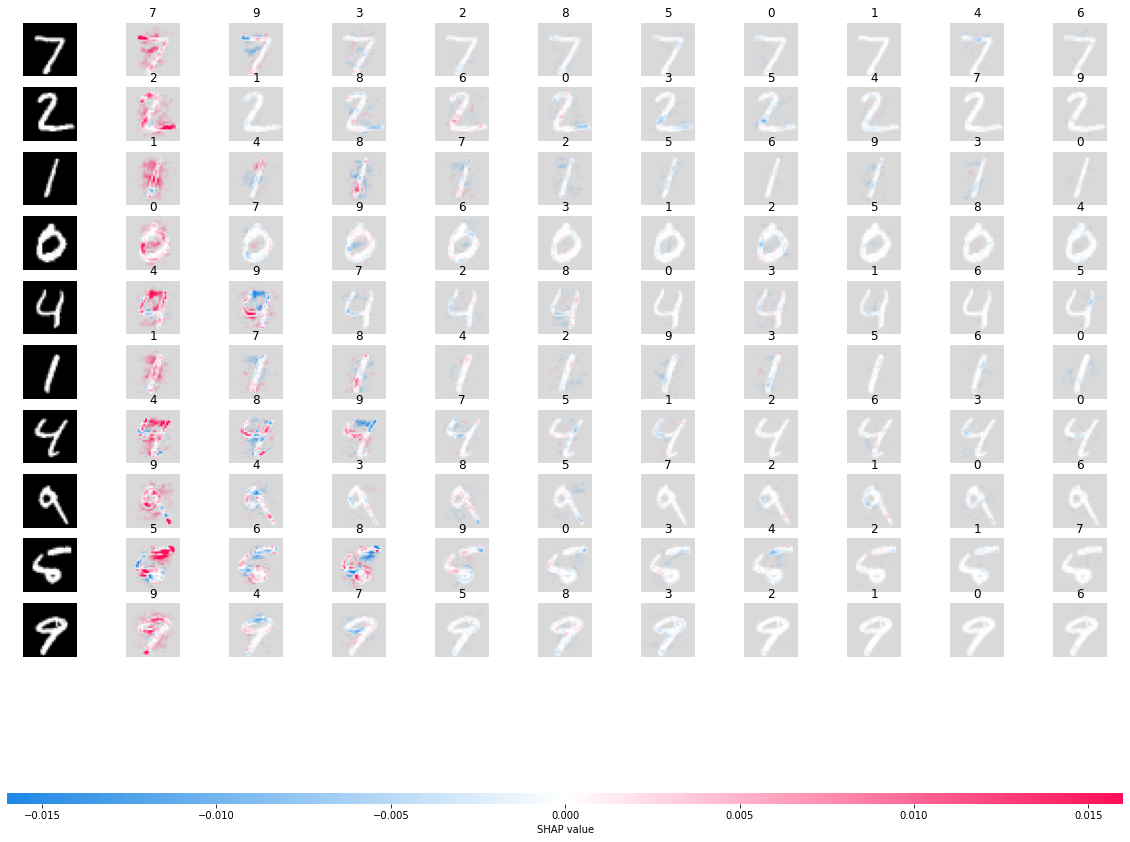

In [12]:
# here we plot the explanations for all classes for the second input (this is the conv-net input)
shap.image_plot([shap_values[i][1] for i in range(10)], x_test[:10],index)

In [13]:
# get the variance of our estimates
shap_values, shap_values_var,index = explainer.shap_values([x_test[:10], x_test[:10]],ranked_outputs=10, return_variances=True)

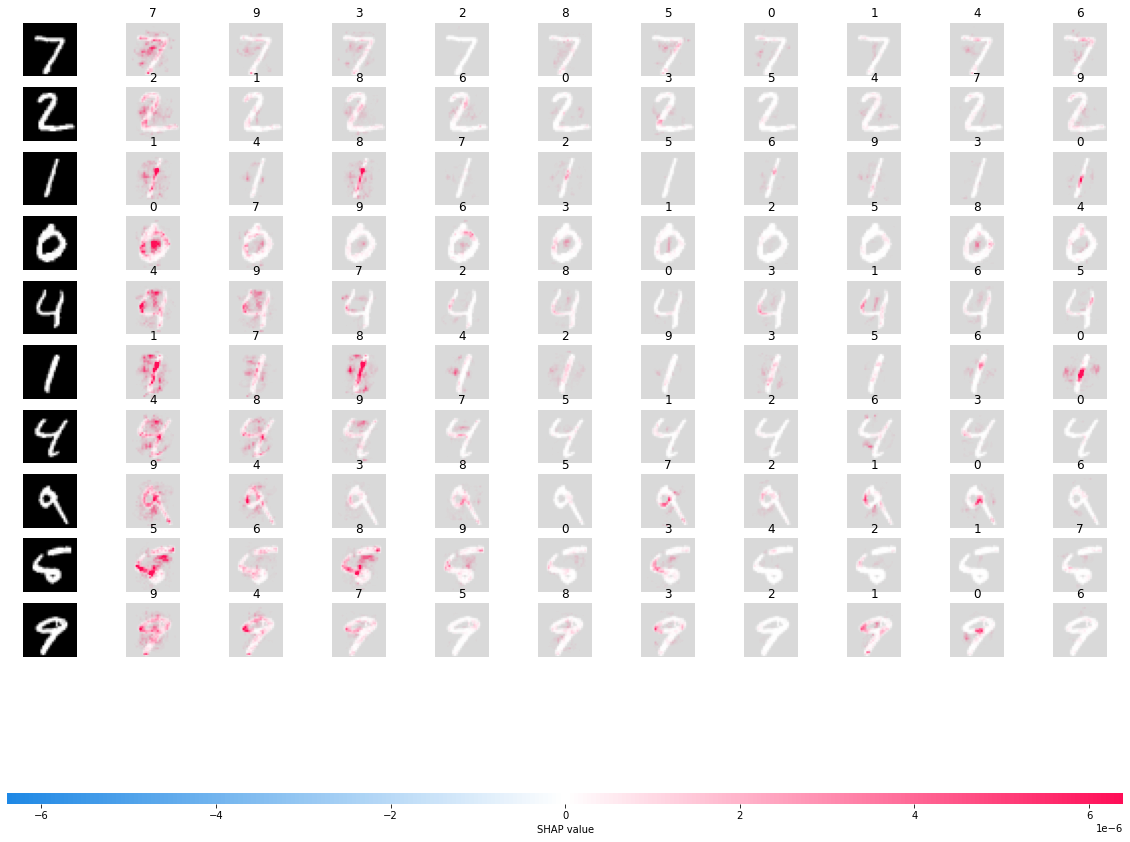

In [14]:
# here we plot the explanations for all classes for the first input (this is the feed forward input)
shap.image_plot([shap_values_var[i][0] for i in range(10)], x_test[:10],index)

In [15]:
np.array(shap_values_var).shape

(10, 2, 10, 28, 28, 1)

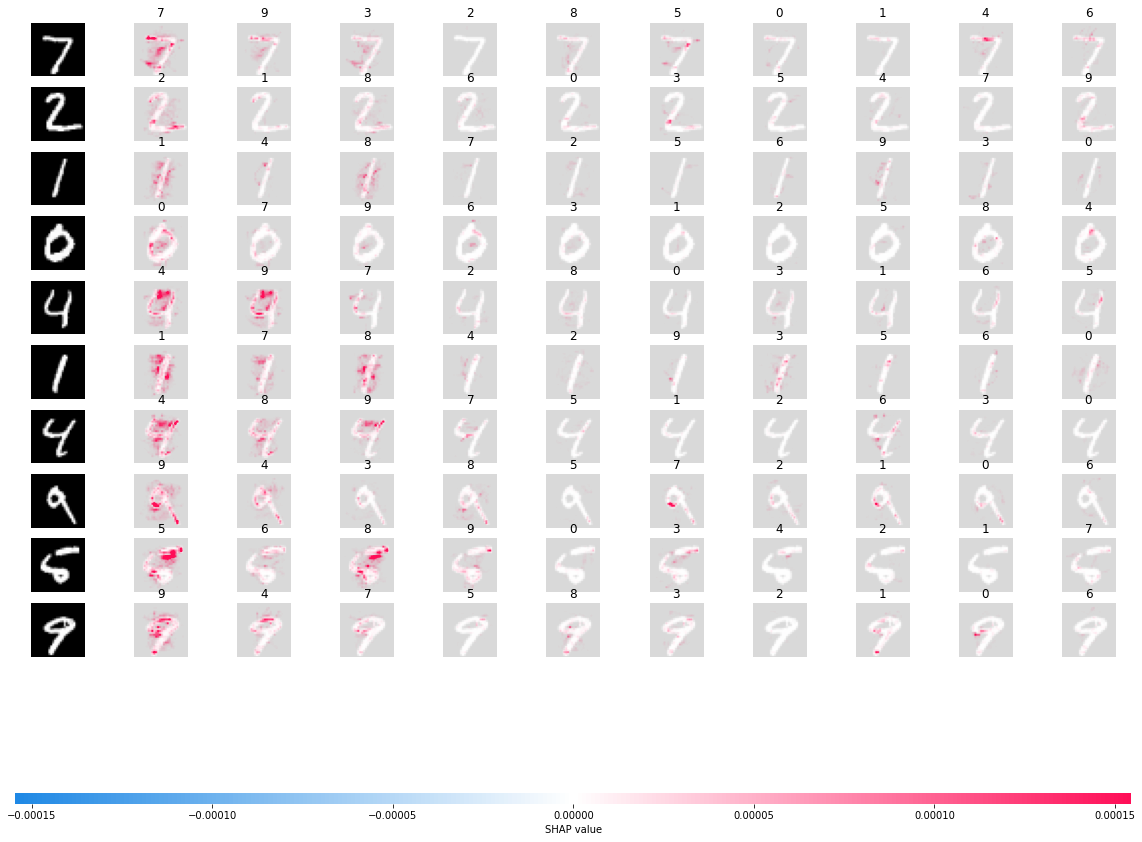

In [16]:
# here we plot the explanations for all classes for the first input (this is the feed forward input)
shap.image_plot([shap_values_var[i][1] for i in range(10)], x_test[:10],index)